In [1]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 5.8 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from typing import Dict, List, Tuple
import pickle
import warnings
from google.colab import files

warnings.filterwarnings('ignore')

In [6]:
FEATURE_COLS = [
    'Electrical speed [rad/s]',
    'I_M_a', 'I_M_b', 'I_M_c',
    'I_P_a', 'I_P_b', 'I_P_c',
    'I_B_a', 'I_B_b', 'I_B_c',
    'V_M_a', 'V_M_b', 'V_M_c',
    'V_P_a', 'V_P_b', 'V_P_c',
    'V_B_a', 'V_B_b', 'V_B_c'
]
LABEL_COL = 'Class label'

In [11]:
uploaded = files.upload()
pkl_name = list(uploaded.keys())[0]

with open(pkl_name, 'rb') as f:
    saved = pickle.load(f)
if isinstance(saved, dict) and 'clf' in saved:
    #sv_transf
    clf = saved['clf']
    scaler = saved['scaler']
    all_classes = np.array(saved['classes'])
    MODEL_TYPE = 'sv_transfer'
else:
    # Format LearnPPNC classique
    model = saved
    clf = None
    scaler = model.scaler
    all_classes = np.array(sorted(model.all_classes))
    MODEL_TYPE = 'learnpp'

Saving learnpp_sv_transfer.pkl to learnpp_sv_transfer (2).pkl


In [12]:
#try on new data
uploaded = files.upload()
test_file = list(uploaded.keys())[0]

df_test = pd.read_csv(test_file)
X_test = df_test[FEATURE_COLS].values
y_test = df_test[LABEL_COL].values

test_classes = sorted(np.unique(y_test))
unknown = set(test_classes) - set(all_classes)
if unknown:
    print(f"\nunknow classes: {sorted(unknown)}")

Saving data_exp8.csv to data_exp8 (3).csv


In [13]:
X_test_sc = scaler.transform(X_test)

if MODEL_TYPE == 'sv_transfer':
    y_pred = clf.predict(X_test_sc)
    y_proba = clf.predict_proba(X_test_sc)
    confidence = np.max(y_proba, axis=1)
else:
    res = model.evaluate(X_test, y_test)
    y_pred = res['y_pred']
    confidence = res['confidence']

acc = accuracy_score(y_test, y_pred)

print("="*60)
print(f"  ACCURACY: {acc:.4f}")
print("="*60)
print(classification_report(y_test, y_pred, zero_division=0))

  ACCURACY: 0.9759
              precision    recall  f1-score   support

           1       0.24      1.00      0.39        45
           2       1.00      1.00      1.00       446
           3       1.00      1.00      1.00       450
           4       1.00      1.00      1.00       455
           5       0.99      1.00      0.99       450
           6       1.00      1.00      1.00       450
           7       1.00      1.00      1.00       450
           8       1.00      0.99      0.99       450
           9       0.98      0.99      0.98       450
          10       1.00      1.00      1.00       450
          11       1.00      0.90      0.95       450
          12       1.00      0.90      0.95       450
          13       1.00      0.90      0.95       450
          14       1.00      0.98      0.99       450
          15       1.00      0.98      0.99       450
          16       0.99      0.99      0.99       450

    accuracy                           0.98      6796
   macr

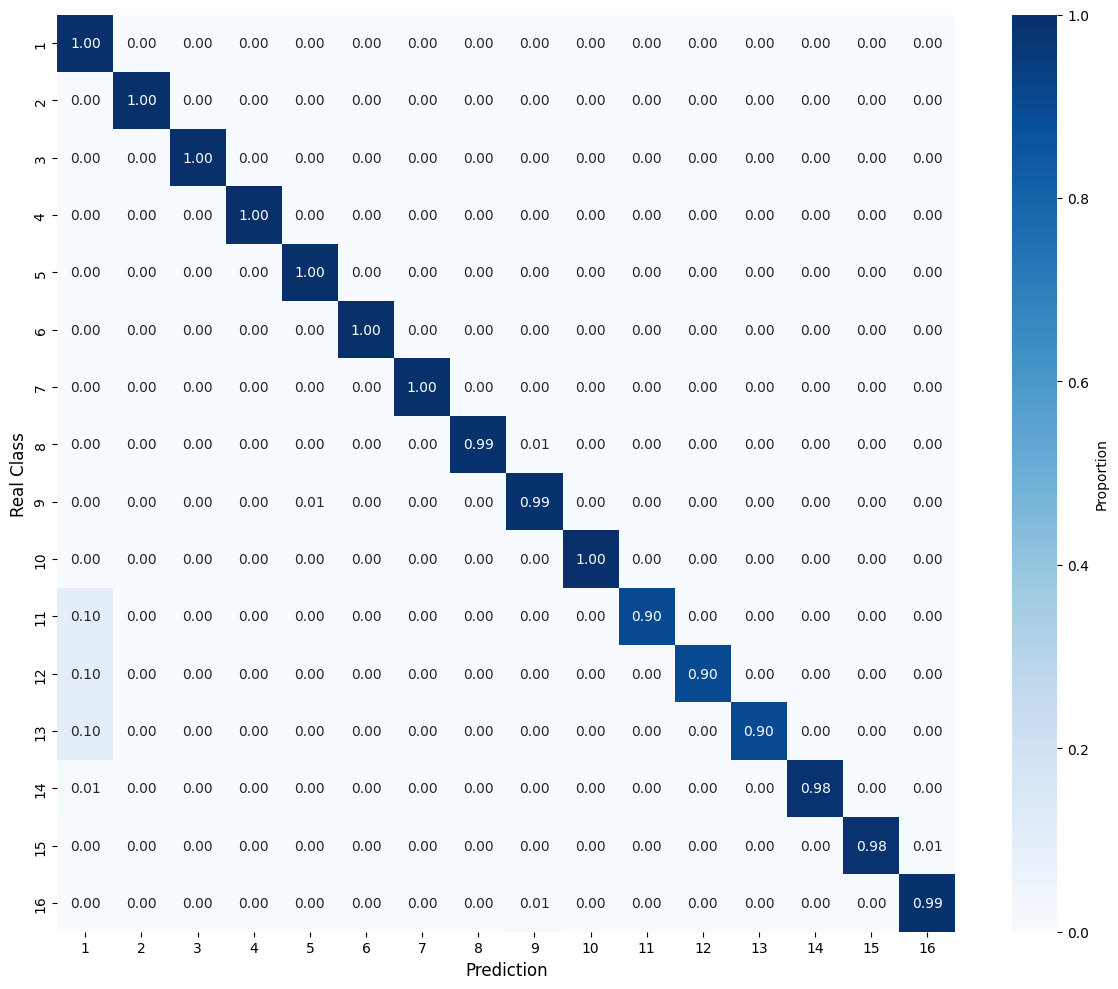

In [15]:

fig, ax = plt.subplots(figsize=(12, 10))

cm = confusion_matrix(y_test, y_pred, labels=all_classes)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=all_classes.astype(int),
            yticklabels=all_classes.astype(int),
            ax=ax, vmin=0, vmax=1,
            cbar_kws={'label': 'Proportion'})

ax.set_xlabel('Prediction', fontsize=12)
ax.set_ylabel('Real Class', fontsize=12)

plt.tight_layout()
plt.savefig('test_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()